In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings
import chess.pgn
import chess.engine
import io
import re

In [2]:
games_df = pd.read_csv('../data/analysis/game_level_analysis.csv')
total_games = len(games_df)

# Calculate wins, losses, and draws
wins = (games_df['Result'] == 'win').sum()
losses = (games_df['Result'] == 'loss').sum()
draws = (games_df['Result'] == 'draw').sum()

# Calculate games played as white and black
games_as_white = (games_df['Side'] == 'white').sum()
games_as_black = (games_df['Side'] == 'black').sum()

summary_df = pd.DataFrame({
    'Total Games': [total_games],
    'Wins': [wins],
    'Losses': [losses],
    'Draws': [draws],
    'Games as White': [games_as_white],
    'Games as Black': [games_as_black]
})
summary_df

,Total Games,Wins,Losses,Draws,Games as White,Games as Black
0,1000,472,496,31,496,504


In [3]:
file_path = '../data/analysis/move_level_analysis.csv'
data = []
with open(file_path, newline='', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=',', quotechar='"')
    for row in reader:
        data.append(row)

moves_df = pd.DataFrame(data[1:], columns=data[0])
moves_df['Evaluation'] = pd.to_numeric(moves_df['Evaluation'], errors='coerce')
moves_df['Move Number'] = pd.to_numeric(moves_df['Move Number'], errors='coerce')
moves_df

,ECO,Opening Name,Phase,Move Number,Move,Evaluation,Material Balance,Evaluation Drop,Blunder Type,Piece Activity,Endgame Type,Side
0,C26,Vienna game,opening,1,e2e4,33,0,-33,NA,20,NA,white
1,C26,Vienna game,opening,2,g8f6,78,0,-45,NA,30,NA,white
2,C26,Vienna game,opening,3,b1c3,14,0,64,NA,22,NA,white
3,C26,Vienna game,opening,4,e7e5,24,0,-10,NA,31,NA,white
4,C26,Vienna game,opening,5,g1f3,21,0,3,NA,27,NA,white
...,...,...,...,...,...,...,...,...,...,...,...,...
57936,B00,King's pawn opening,end,82,g7h6,447,5,-19,NA,39,Queen Endgame,white
57937,B00,King's pawn opening,end,83,g8f8,441,5,6,NA,3,Queen Endgame,white
57938,B00,King's pawn opening,end,84,h6h5,481,5,-40,NA,39,Queen Endgame,white
57939,B00,King's pawn opening,end,85,f8f6,-9999,5,10480,strategic,42,Queen Endgame,white


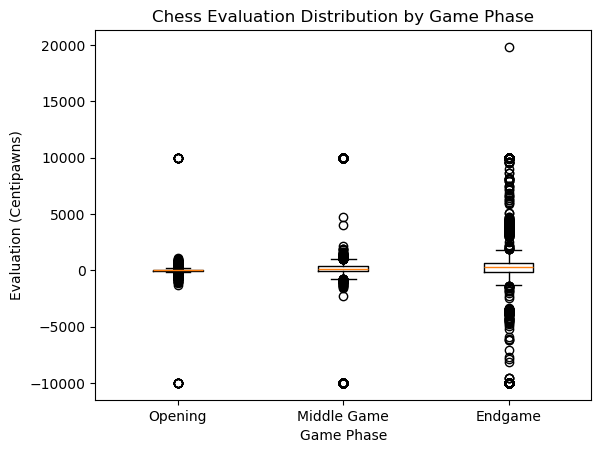

In [4]:
# Separate data into different phases
opening_evals = moves_df[moves_df['Phase'] == 'opening']['Evaluation']
middle_evals = moves_df[moves_df['Phase'] == 'middle']['Evaluation']
end_evals = moves_df[moves_df['Phase'] == 'end']['Evaluation']

# Plotting evaluations for each phase in box plots
data = [opening_evals, middle_evals, end_evals]
phases = ['Opening', 'Middle Game', 'Endgame']

plt.boxplot(data, labels=phases)
plt.title('Chess Evaluation Distribution by Game Phase')
plt.xlabel('Game Phase')
plt.ylabel('Evaluation (Centipawns)')
plt.savefig('../results/game_phase_box_plot.jpg', format='jpg')
plt.show()

Opening evaluation:

We can see that our opening is the weakest part of our game so let's do a further investigation into the strengths and weaknesses (mostly weaknesses) of my opening theory. 

                             Opening Name  game_count
2                       Caro-Kann defence         373
24                    Two knights defence          89
17                           Queen's pawn          66
5                            Giuoco Piano          60
23                       Sicilian defence          51
6                            Italian Game          48
15                           Pirc defence          41
12                     Old Indian defence          35
22  Scandinavian (centre counter) defence          35
14                     Philidor's defence          34


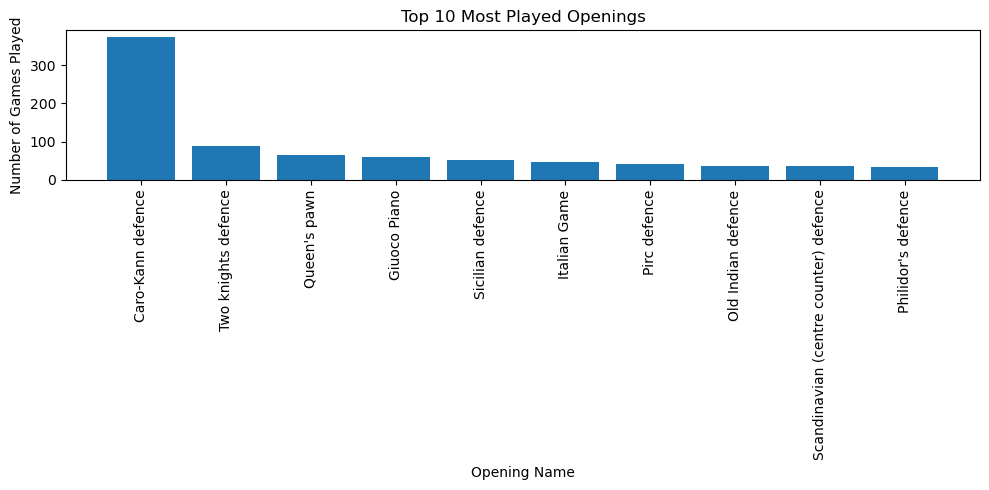

In [5]:
eco_mapping = pd.read_csv('../data/processed/cleaned_ECO_table.csv')

grouped_openings = games_df.groupby('Opening Name').agg(game_count=('Opening Name', 'size')).reset_index()

# Get top most played openings
top_openings = grouped_openings.sort_values(by='game_count', ascending=False).head(10)
print(top_openings)

plt.figure(figsize=(10, 5))
plt.bar(top_openings['Opening Name'], top_openings['game_count'])
plt.title('Top 10 Most Played Openings')
plt.xlabel('Opening Name')
plt.ylabel('Number of Games Played')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../results/frequent_openings.jpg', format='jpg')
plt.show()

We have similar name's for some of the openings as they are different variations. For example, we see "Queen's pawn" multiple times and we see "Caro-Kann" multiple times as well, but these are different variations.

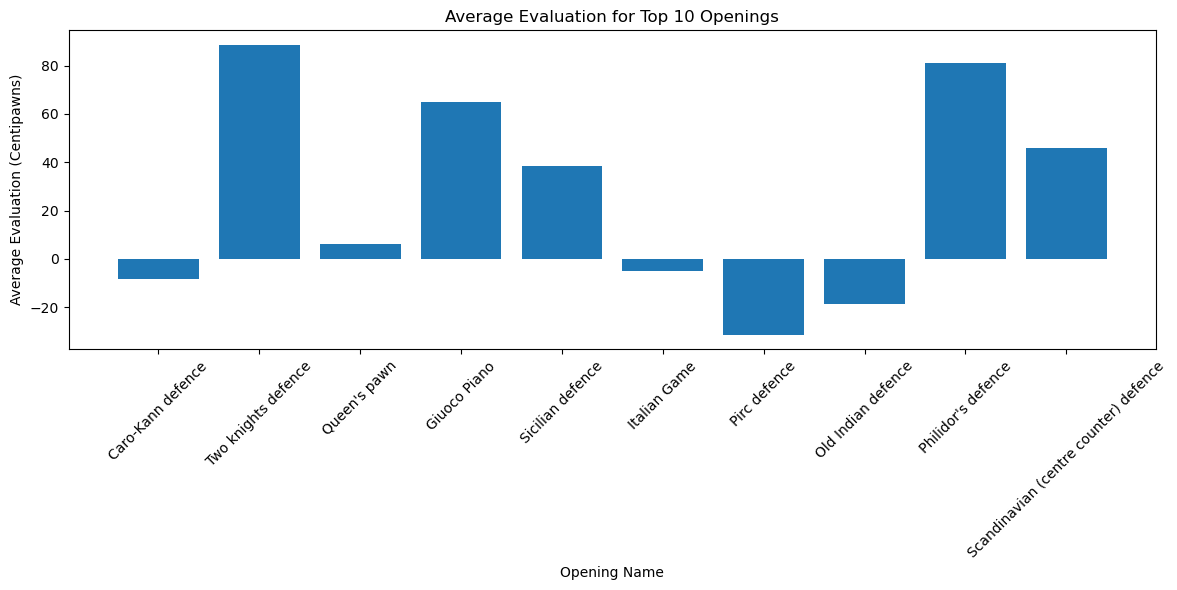

In [6]:
# Filter for opening phase
opening_phase_df = moves_df[moves_df['Phase'] == 'opening']
avg_eval_opening = opening_phase_df.groupby(['Opening Name'])['Evaluation'].mean().reset_index()

# Merge with the count of games per opening
count_games = opening_phase_df.groupby(['Opening Name']).size().reset_index(name='Game Count')
avg_eval_opening = avg_eval_opening.merge(count_games, on=['Opening Name'])

# Sort by Game Count and select top 10 openings
top_openings = avg_eval_opening.sort_values(by='Game Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_openings['Opening Name'], top_openings['Evaluation'])
plt.title('Average Evaluation for Top 10 Openings')
plt.xlabel('Opening Name')
plt.ylabel('Average Evaluation (Centipawns)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/frequent_openings_eval.jpg', format='jpg')
plt.show()

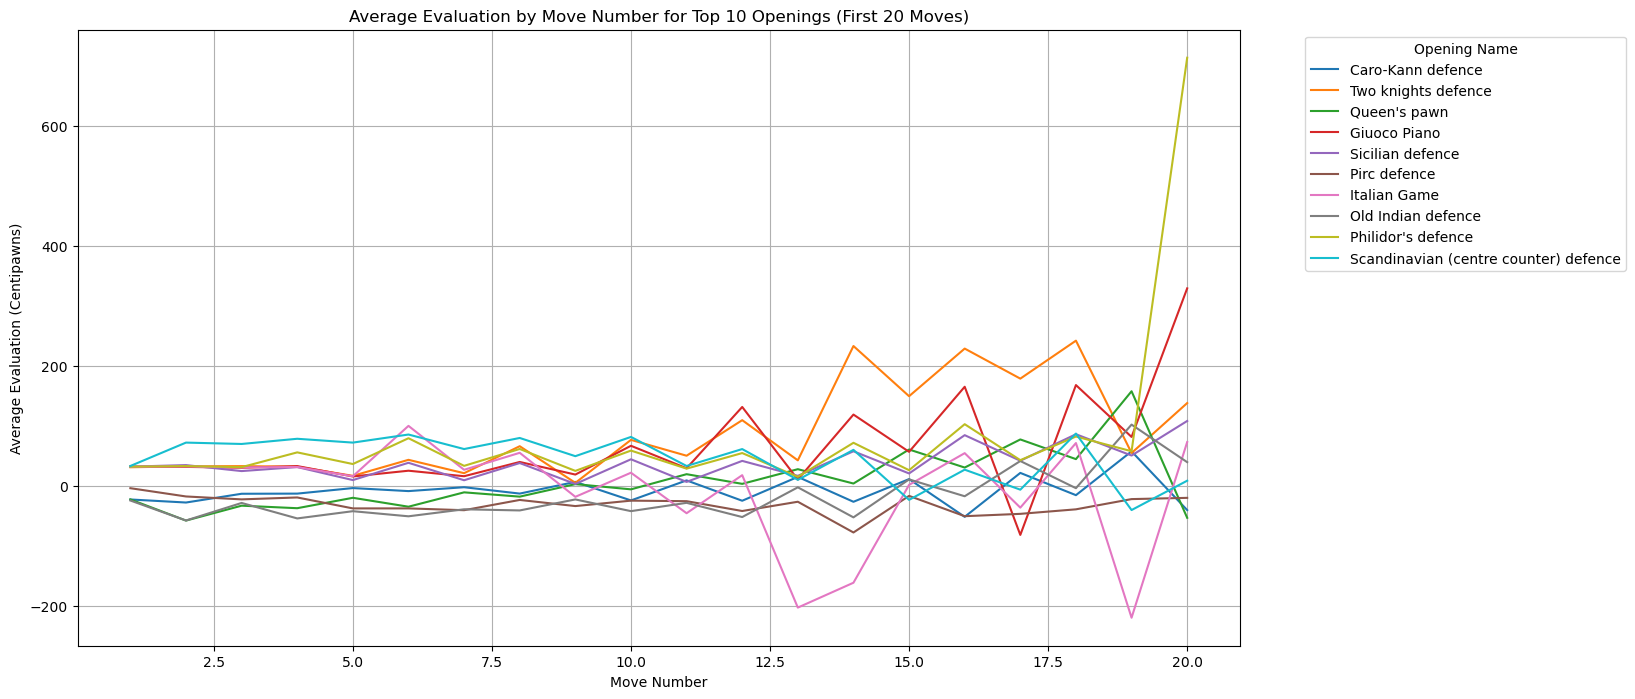

In [7]:
# Calculate the top 10 most played openings
top_openings = moves_df['Opening Name'].value_counts().head(10).index

eval_by_move = pd.DataFrame()

# Calculate and plot average evaluations by move number for each of the top 10 openings
for opening in top_openings:
    opening_data = moves_df[(moves_df['Opening Name'] == opening) & (moves_df['Move Number'] <= 20)]
    average_evals = opening_data.groupby('Move Number')['Evaluation'].mean()
    eval_by_move[opening] = average_evals

plt.figure(figsize=(15, 8))
for opening in top_openings:
    plt.plot(eval_by_move.index, eval_by_move[opening], label=opening)

plt.title('Average Evaluation by Move Number for Top 10 Openings (First 20 Moves)')
plt.xlabel('Move Number')
plt.ylabel('Average Evaluation (Centipawns)')
plt.legend(title='Opening Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig('../results/avg_eval_by_move_no.jpg', format='jpg')
plt.show()

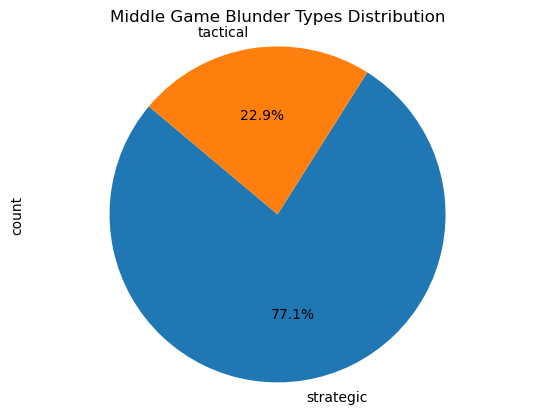

In [8]:
middle_game_blunders = moves_df[(moves_df['Phase'] == 'middle') & (moves_df['Blunder Type'] != 'NA')]

blunder_distribution = middle_game_blunders['Blunder Type'].value_counts()

blunder_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Middle Game Blunder Types Distribution')
plt.savefig('../results/blunder_type_dist.jpg', format='jpg')
plt.show()

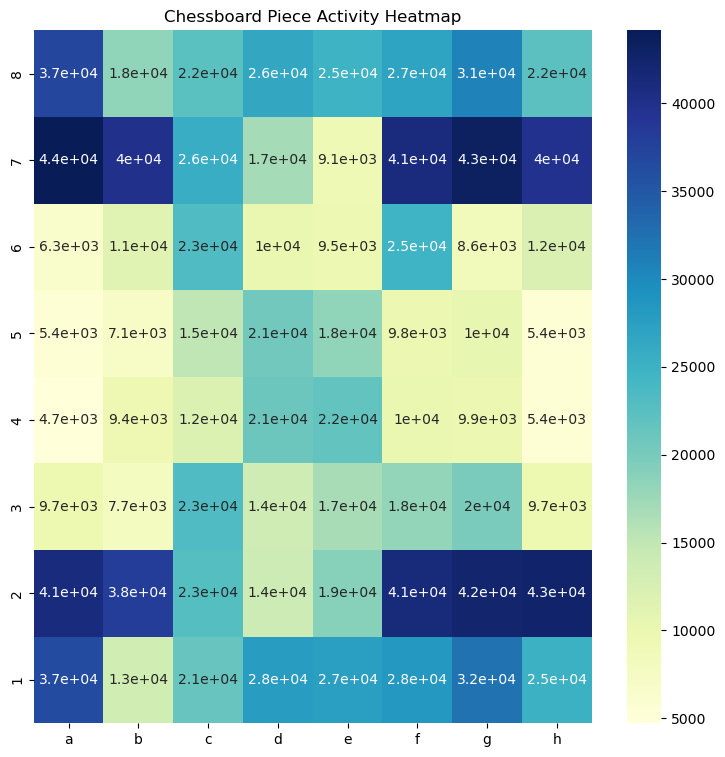

In [9]:
def update_board_heatmap(board, heatmap):
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:  # If a piece is present on the square
            row, col = divmod(square, 8)
            heatmap[row, col] += 1

# Initialize a heatmap matrix
board_heatmap = np.zeros((8, 8))

pgn_df = pd.read_csv('../data/processed/processed_games.csv')

# Process each game
for pgn in pgn_df['pgn']:
    game = chess.pgn.read_game(io.StringIO(pgn))
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        update_board_heatmap(board, board_heatmap)

# Create the heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(board_heatmap, annot=True, cmap="YlGnBu", xticklabels=chess.FILE_NAMES, yticklabels=list(reversed(chess.RANK_NAMES)))
plt.title('Chessboard Piece Activity Heatmap')
plt.savefig('../results/board_heatmap.jpg', format='jpg')
plt.show()

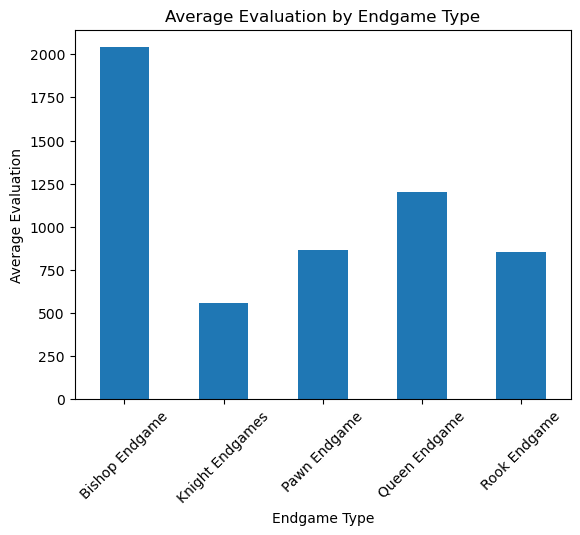

In [10]:
end_game_data = moves_df[moves_df['Phase'] == 'end']
avg_eval_by_endgame = end_game_data.groupby('Endgame Type')['Evaluation'].mean()
avg_eval_by_endgame = avg_eval_by_endgame[avg_eval_by_endgame != 0]

avg_eval_by_endgame.plot(kind='bar')
plt.title('Average Evaluation by Endgame Type')
plt.xlabel('Endgame Type')
plt.ylabel('Average Evaluation')
plt.xticks(rotation=45)
plt.savefig('../results/avg_eval_by_endgame.jpg', format='jpg')
plt.show()